# 📊 02 - Exploración de Datos (EDA)

En este notebook se realiza un análisis exploratorio sobre el dataset `train.csv` de la competencia Titanic. Se identifican valores faltantes, distribución de variables, correlaciones y posibles relaciones entre las características y la variable objetivo `Survived`.

---

📁 Fuente: `../data/train.csv`


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Ruta de los datos
df = pd.read_csv("../data/train.csv")

# Vista general
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
print("[INFO] Dimensiones del dataset:", df.shape)
df.info()


[INFO] Dimensiones del dataset: (891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


---

## 📌 Resumen estructural del dataset

- Total de registros: **891**
- Total de columnas: **12**
- Columnas numéricas: `PassengerId`, `Survived`, `Pclass`, `Age`, `SibSp`, `Parch`, `Fare`
- Columnas categóricas: `Sex`, `Embarked`, `Pclass` (ordinal), `Cabin` (alta cardinalidad), `Ticket` (texto libre), `Name` (no estructurada)
- Columnas con valores nulos:
  - `Age`: 177 valores faltantes (≈ 20%)
  - `Cabin`: 687 valores faltantes (≈ 77%)
  - `Embarked`: 2 valores faltantes
- `Cabin` parece tener muchos valores únicos, lo que podría requerir tratamiento especial (eliminar, agrupar o extraer letra de cabina)
- `Name` puede usarse para extraer título social (`Mr.`, `Mrs.`, `Miss`, etc.)

---

Este análisis es útil para definir las estrategias de limpieza y feature engineering en los siguientes pasos.



[INFO] Columnas con valores nulos:


Cabin       687
Age         177
Embarked      2
dtype: int64

C:\Users\apont\AppData\Local\Temp\ipykernel_27496\1642919063.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values, y=missing.index, palette="flare")


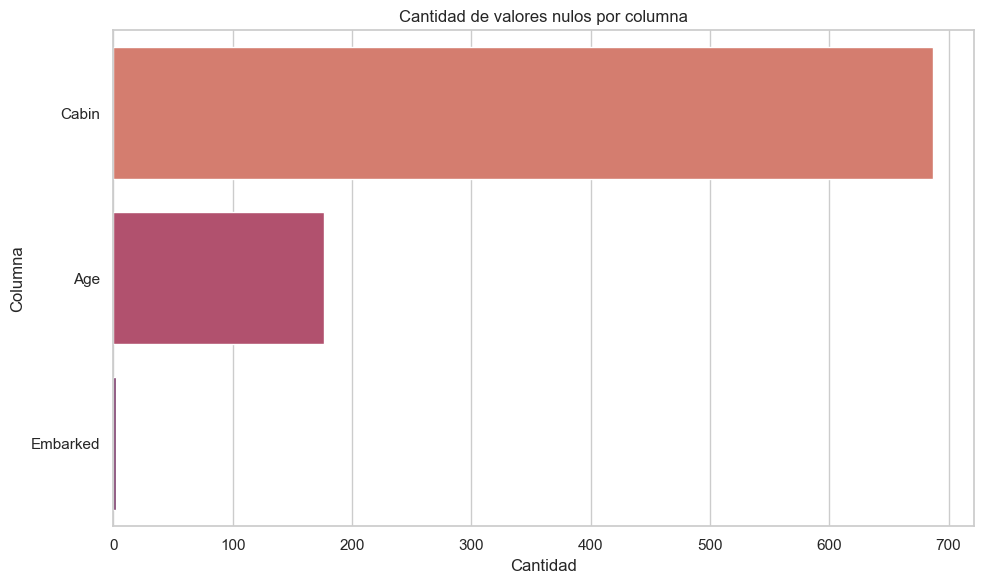

In [3]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("[INFO] Columnas con valores nulos:")
display(missing)

# Gráfico de valores nulos
sns.barplot(x=missing.values, y=missing.index, palette="flare")
plt.title("Cantidad de valores nulos por columna")
plt.xlabel("Cantidad")
plt.ylabel("Columna")
plt.tight_layout()
plt.show()


---

## 📉 Análisis de valores nulos

El análisis visual muestra tres columnas con valores faltantes:

| Columna   | Valores nulos | Porcentaje aproximado |
|-----------|----------------|------------------------|
| `Cabin`   | 687 de 891     | ≈ 77%                  |
| `Age`     | 177 de 891     | ≈ 20%                  |
| `Embarked`| 2 de 891       | < 0.3%                 |

### 🔍 Observaciones:

- `Cabin` tiene una **alta proporción de valores nulos**. Debido a su baja disponibilidad, debe evaluarse si:
  - Se elimina la columna,
  - Se transforma extrayendo la letra de la cabina (`C`, `E`, etc.) como categoría ordinal,
  - O se agrupa como “Cabina conocida” vs “Cabina desconocida”.

- `Age` representa una variable continua importante. Requiere imputación:
  - Media, mediana o
  - Modelado basado en grupos (`Pclass`, `Sex`, `Title` extraído de `Name`, etc.)

- `Embarked` tiene solo 2 valores faltantes, por lo que se puede imputar directamente con la moda (`S`).

---


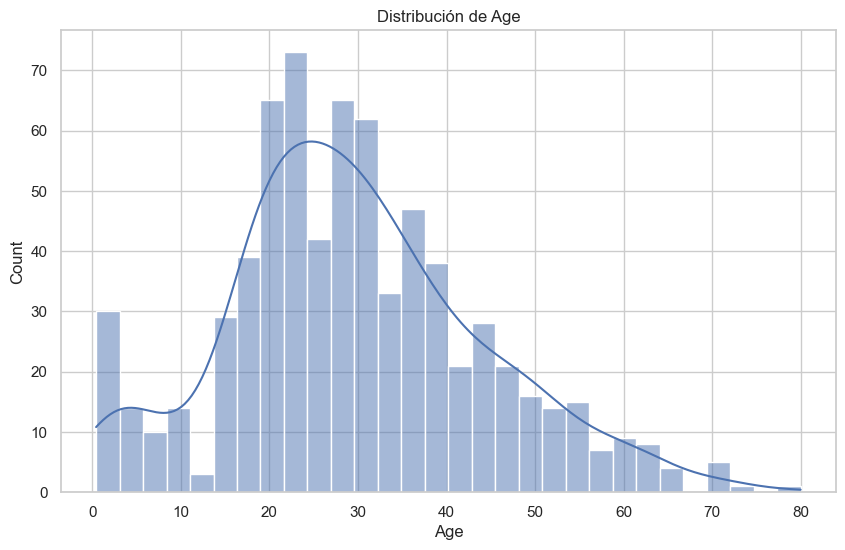

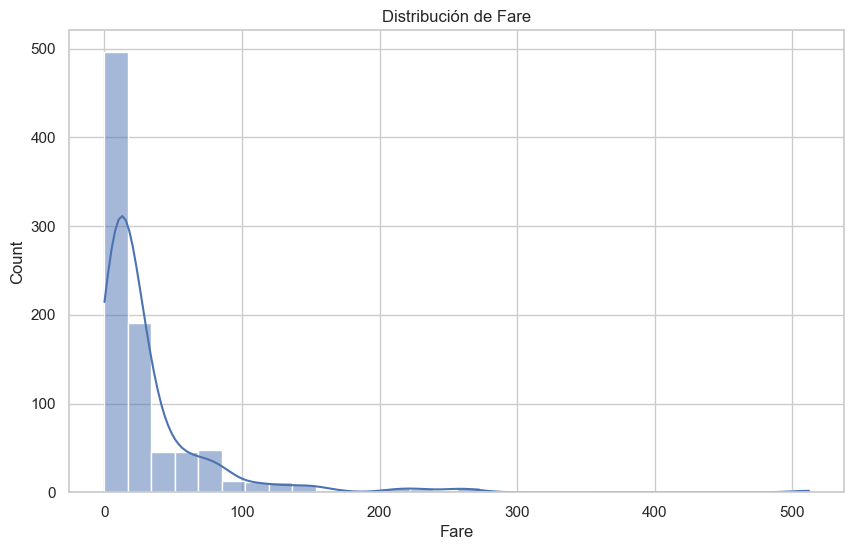

In [4]:
# Distribución de variables numéricas
num_cols = ['Age', 'Fare']

for col in num_cols:
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribución de {col}")
    plt.show()


---

## 📊 Distribución de variables numéricas

### 🔹 `Age` (Edad)

- La distribución de edad tiene una **forma asimétrica hacia la derecha**, con un pico entre los **20 y 30 años**.
- Existe una concentración de niños pequeños (< 5 años) y también algunos valores extremos por encima de los 70.
- La mediana visual parece estar alrededor de los 28 años.
- Esta variable puede ser sensible a **imputaciones por grupo** (ej. `Sex` + `Pclass` + `Title`) debido a su importancia para la supervivencia.

### 🔹 `Fare` (Tarifa)

- La distribución de la tarifa pagada es **altamente sesgada a la derecha**, con la mayoría de los valores por debajo de los **50 unidades monetarias**.
- Se observan **valores atípicos (outliers)** por encima de los 100, llegando incluso a 500.
- Este comportamiento sugiere que `Fare` podría beneficiarse de una **transformación logarítmica** (`np.log1p`) para estabilizar la varianza antes de aplicarla a modelos.

---

Ambas variables numéricas muestran distribuciones que justifican un tratamiento especial durante el preprocesamiento (imputación o transformación).



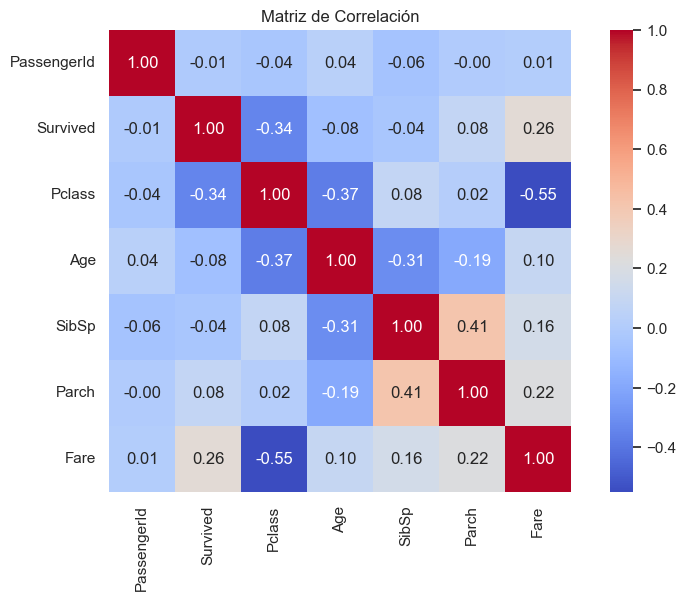

In [5]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación")
plt.show()


---

## 📈 Matriz de correlación

La matriz de correlación muestra las relaciones lineales entre las variables numéricas del dataset. Algunas observaciones clave:

### 🔍 Correlaciones relevantes con `Survived`:

| Variable | Correlación con `Survived` | Interpretación                             |
|----------|-----------------------------|--------------------------------------------|
| `Fare`   | **+0.26**                   | A mayor tarifa pagada, mayor probabilidad de supervivencia. Posible indicador de clase social. |
| `Pclass` | **−0.34**                   | Clase 3 (más baja) asociada a menor supervivencia. |
| `Age`    | −0.08                       | Leve correlación negativa, no concluyente. |
| `SibSp`, `Parch` | ±0.04 ~ 0.08        | Correlaciones bajas. Puede ser útil combinarlas en una sola feature (`FamilySize`). |

### 🔁 Correlaciones entre variables independientes:

- `Pclass` y `Fare`: **−0.55** → fuerte correlación negativa, lo que es esperable ya que la clase más baja pagó menos.
- `SibSp` y `Parch`: **+0.41** → ambos representan relaciones familiares, lo que sugiere agruparlos en una variable compuesta.

### 🧼 Recomendaciones:

- `Pclass` y `Fare` son variables útiles para los modelos y deben mantenerse.
- `SibSp` + `Parch` → considerar crear `FamilySize = SibSp + Parch + 1`.
- `PassengerId` no tiene correlación ni valor predictivo → se puede eliminar antes de entrenar modelos.

---


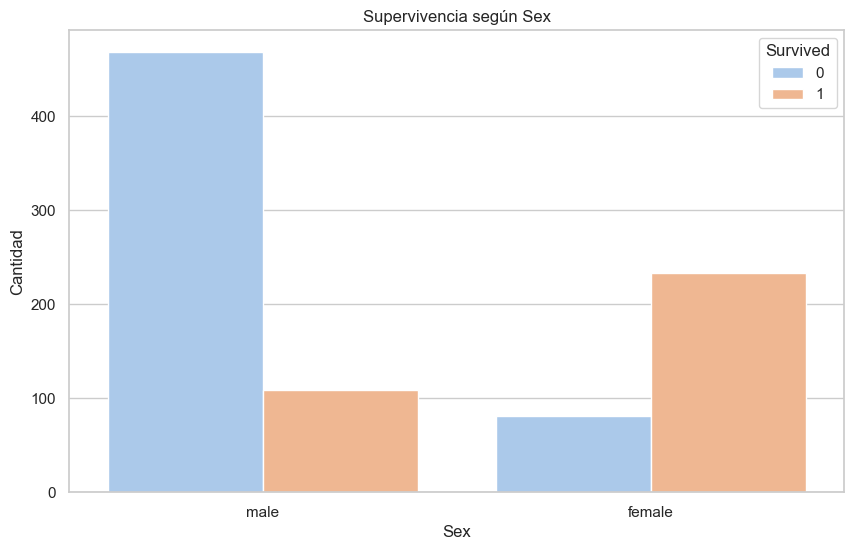

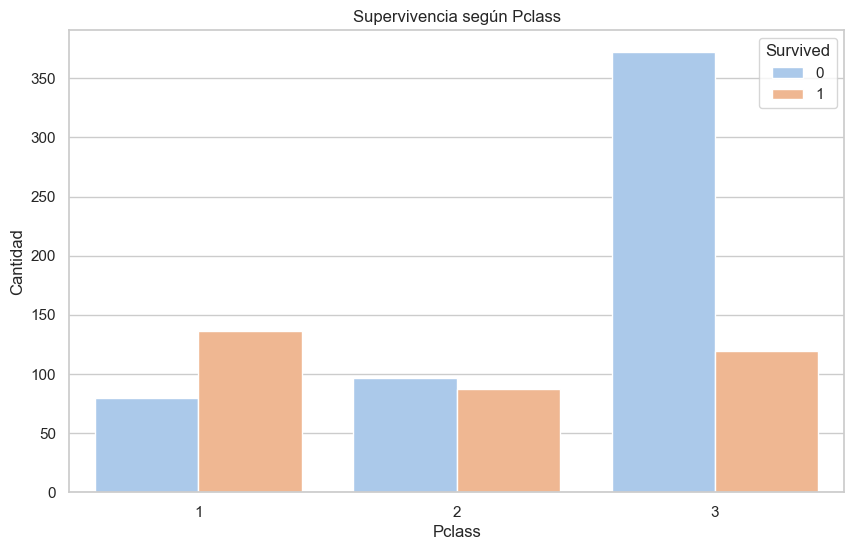

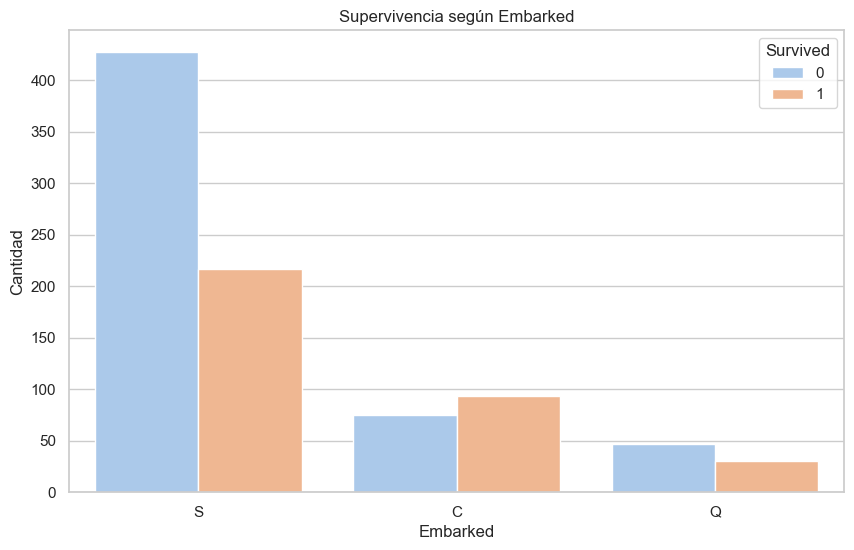

In [6]:
cat_cols = ['Sex', 'Pclass', 'Embarked']

for col in cat_cols:
    sns.countplot(x=col, hue="Survived", data=df, palette="pastel")
    plt.title(f"Supervivencia según {col}")
    plt.ylabel("Cantidad")
    plt.show()


---

## 📊 Análisis de variables categóricas frente a la variable objetivo `Survived`

### 🔹 `Sex` (Género)

- Se observa una **diferencia muy marcada** entre hombres y mujeres.
- La **mayoría de los hombres no sobrevivió**, mientras que **más del 70% de las mujeres sí sobrevivió**.
- Esta variable muestra un **alto poder predictivo** y debe ser considerada fundamental en el modelado.
- Se recomienda su transformación a variable binaria (`0=male`, `1=female`).

---

### 🔹 `Pclass` (Clase de boleto)

- Existe una **tendencia clara de mayor supervivencia en las clases altas**:
  - **Primera clase (`Pclass=1`)** tiene la mayor proporción de supervivencia.
  - **Tercera clase (`Pclass=3`)** tiene la mayor cantidad de muertes.
- Refleja una dimensión socioeconómica que afecta fuertemente la probabilidad de sobrevivir.
- Se recomienda mantener esta variable tal como está (ordinal), o codificarla en variables dummy para ciertos modelos.

---

### 🔹 `Embarked` (Puerto de embarque)

- La mayoría de los pasajeros embarcaron en `S` (Southampton), y también es el grupo con menor proporción de supervivencia.
- Los pasajeros embarcados en `C` (Cherburgo) muestran **mejores tasas de supervivencia**.
- `Q` (Queenstown) tiene un tamaño reducido y menor tasa de supervivencia.
- Aunque su correlación directa no es fuerte, puede aportar valor cuando se combina con otras variables (`Pclass`, `Fare`).
- Se sugiere codificarla como variable categórica con `OneHotEncoding`.

---


---

## ✅ Conclusiones del EDA

- Las columnas `Cabin` (≈77%) y `Age` (≈20%) presentan valores nulos significativos. `Embarked` tiene solo 2 valores faltantes.
- La variable `Sex` muestra una **fuerte relación con la supervivencia**: las mujeres sobrevivieron en mayor proporción que los hombres.
- La variable `Pclass` presenta un **comportamiento inverso**: los pasajeros de primera clase tuvieron una tasa de supervivencia mucho más alta que los de tercera clase.
- `Fare` tiene una **distribución muy sesgada** a la derecha y podría beneficiarse de una transformación logarítmica (`log1p`) para estabilizar su escala.
- `Age` muestra una distribución ligeramente sesgada hacia la derecha, con una concentración entre los 20 y 30 años. Es candidata a imputación inteligente por grupos.
- `Embarked` tiene predominancia en `S` (Southampton), pero los pasajeros que embarcaron en `C` (Cherburgo) tuvieron mejores tasas de supervivencia.
- `Pclass` y `Fare` están fuertemente correlacionadas (-0.55), lo que sugiere una relación socioeconómica fuerte entre clase y precio del boleto.
- `SibSp` y `Parch` están moderadamente correlacionadas y podrían combinarse en una nueva variable `FamilySize`.
- Variables como `Sex`, `Pclass`, `Fare`, y posiblemente `Embarked` se consideran claves para la predicción.

---

📌 En el siguiente paso (`03_modelo_baseline.ipynb`), se iniciará el entrenamiento de un modelo base para generar una primera predicción sin ingeniería de variables avanzada, que servirá como línea base de comparación.

---
